# Statistics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
EXPORT_DPI = 100
EXPORT_FIG_SIZE = (8, 4 )
EXPORT_FIG_WIDTH, EXPORT_FIG_HEIGHT = EXPORT_FIG_SIZE

In [3]:
from glob import glob 
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn import dummy
import sys
import os
import helper

USED_FOLDER = '2017-09-13_21:33'
USED_FOLDER = None

result_folders = [x for x in glob('data/results/2017*') if os.path.isdir(x)]

folder = 'data/results/{}'.format(USED_FOLDER) if USED_FOLDER else result_folders[-1]

print('Using result folder: {}'.format(folder))

df_all_ = None
for result_file in helper.log_progress(glob('{}/*.npy'.format(folder))):
    with open(result_file, 'rb') as f:
        result = pickle.load(f)
    dataset = result_file.split('/')[-1].rsplit('.', 2)[0]
    is_graph_dataset = 'graph' in dataset
    is_cooccurrence_dataset = 'cooccurrence' in dataset
    
    dataset_name = dataset

    result['combined'] = 'combined' in result_file
    if is_graph_dataset:
        result['same_label'] = 'same-label' in result_file
        is_simple_kernel = '.simple.' in result_file
        if is_simple_kernel:
            result['kernel'] = 'simple_set_matching'
        else:
            result['kernel'] = 'spgk' if 'spgk' in result_file else 'wl'
        is_relabeled = 'relabeled' in result_file
        result['relabeled'] = is_relabeled
        if is_relabeled:
            topn = result_file.split('topn-')[1].split('_')[0]
            threshold = result_file.split('threshold-')[1].split('_')[0]
            result['topn'] = int(topn)
            result['threshold'] = float(threshold)
        if result['kernel'] == 'wl':
            result['wl_iteration'] = dataset.split('.')[-1]
        parts = dataset.split('_')
        if is_cooccurrence_dataset:
            dataset_name = parts[-1].split('_')[0].split('.')[0]
            result['words'] = parts[4]
            result['window_size'] = parts[3]
        # GML
        else:
            dataset_name = parts[-1].split('.')[0]
            result['words'] = 'concepts'
        result['type'] = 'cooccurrence' if is_cooccurrence_dataset else 'concept-graph'
    else:
        result['type'] = 'text'
        dataset_name = dataset.split('_')[1]
        #result['words'] = ['all' if x['preprocessing'] != None else 'only-nouns'  for x in result['params']]
        result['words'] = ['all' for x in result['params']]
        #result['words'] = result['params']['preprocessing']
    result['classifier'] = [None] * len(result['params'])
    
    for idx, param in enumerate(result['params']):
        result['classifier'][idx] = type(param['clf']).__name__
        del param['clf']
    
    dataset_name = dataset_name.replace('-single', '').replace('-ana', '')
        
    result['filename'] = result_file
    result['dataset'] = dataset_name
    
    is_lemmatized = '_lemmatized_' in result_file
    result['lemmatized'] = is_lemmatized
    
    if dataset_name.endswith('-single') or dataset_name.endswith('-ana'):
        dataset_name = dataset_name.rsplit('-', 1)[0]
    del result['param_clf']
    
    result_df = pd.DataFrame(result).sort_values(by = 'dataset', ascending = False)
    df_all_ = result_df if df_all_ is None else df_all_.append(result_df)

assert df_all_ is not None
assert df_all_.shape[0]
    
# Only keep datasets where there are all three types (text, co-occurence and concept-graph) of results
df_all = df_all_.groupby('dataset').filter(lambda x: len(x.type.value_counts()) == 3).reset_index(drop=True)

Using result folder: data/results/2017-09-28_13:47


Widget Javascript not detected.  It may not be installed or enabled properly.


In [4]:
sns.set('notebook', 'whitegrid', palette='deep')
#sns.set('notebook', 'whitegrid', palette='pastel')

In [5]:
df_all[df_all.classifier == 'DummyClassifier'].groupby('dataset').mean_test_f1_macro.max().to_frame()

,mean_test_f1_macro
dataset,
ling-spam,0.458532
ng20,0.005613
reuters-21578,0.005215
webkb,0.140260


In [6]:
df_all_.dataset.value_counts().to_frame()

,dataset
reuters-21578,7446
ling-spam,3774
ng20,1738
webkb,1330


In [7]:
coo = df_all_.filename.str.contains('coo')
gml = df_all_.filename.str.contains('gml')
df_all_[(df_all_.dataset == 'webkb')][['filename', 'classifier', 'mean_test_f1_macro', 'wl_iteration', 'window_size']].sort_values(by = 'mean_test_f1_macro', ascending=False)
df_all_.groupby('dataset').type.value_counts()

dataset        type         
ling-spam      cooccurrence     3288
               concept-graph     482
               text                4
ng20           cooccurrence     1248
               concept-graph     482
               text                8
reuters-21578  cooccurrence     6960
               concept-graph     482
               text                4
webkb          cooccurrence      840
               concept-graph     482
               text                8
Name: type, dtype: int64

## Result distributions

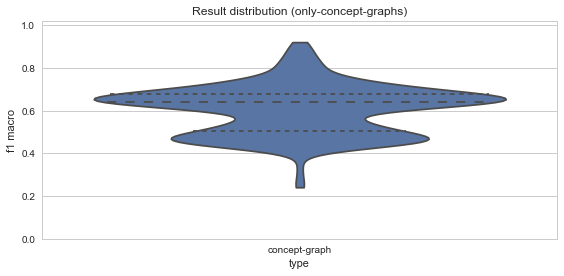

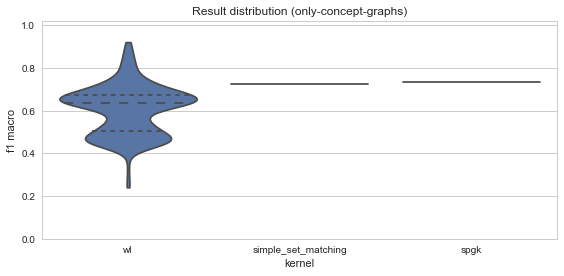

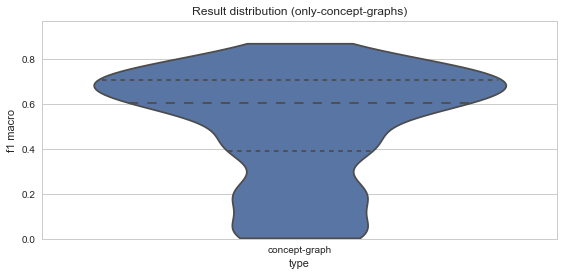

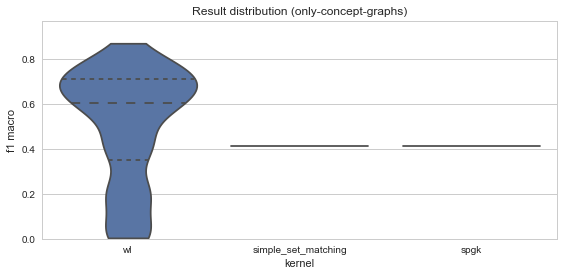

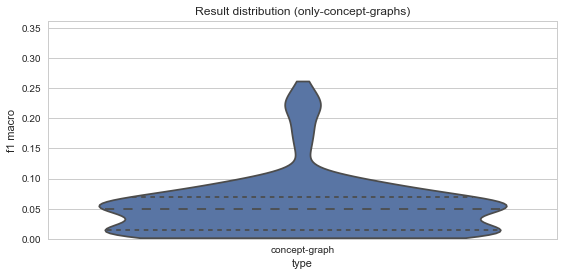

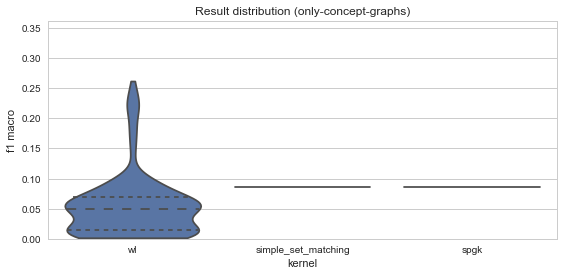

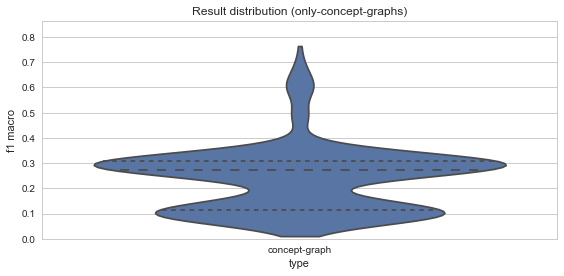

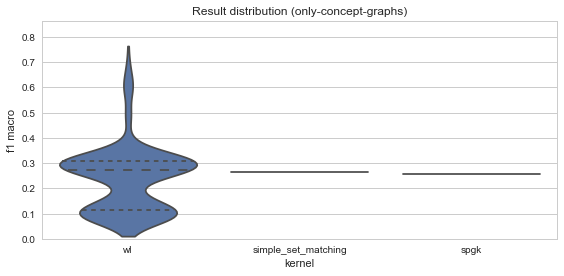

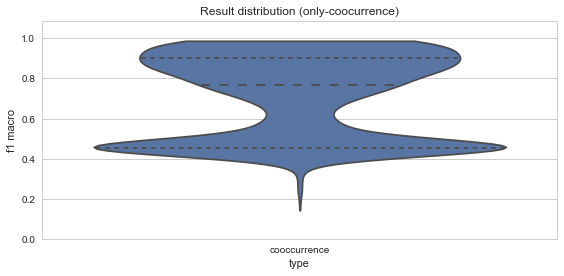

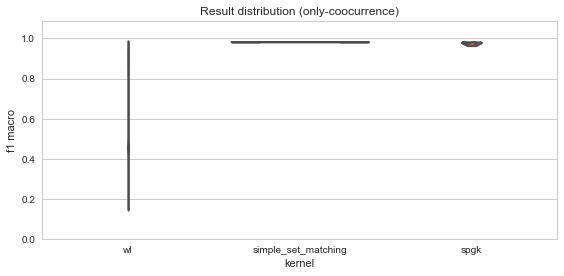

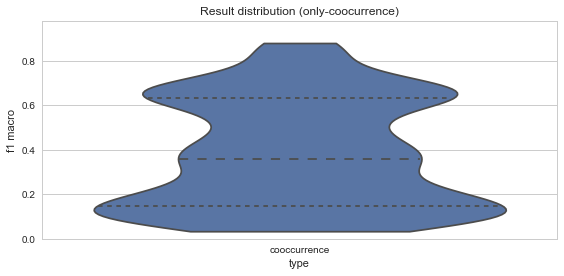

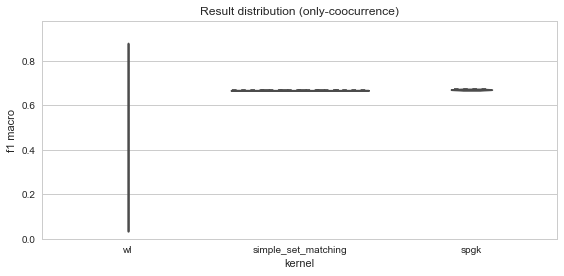

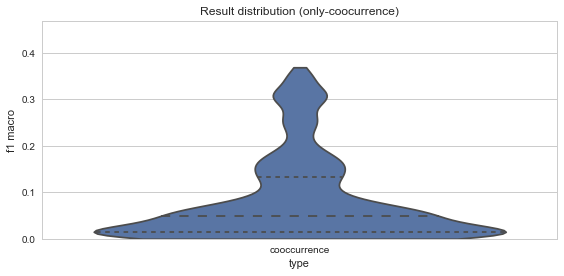

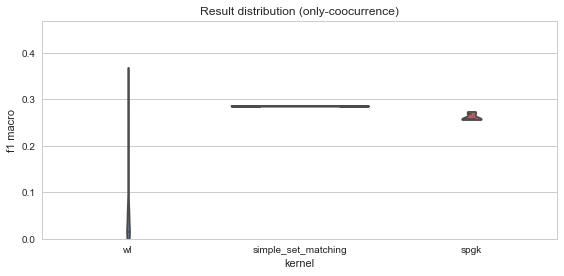

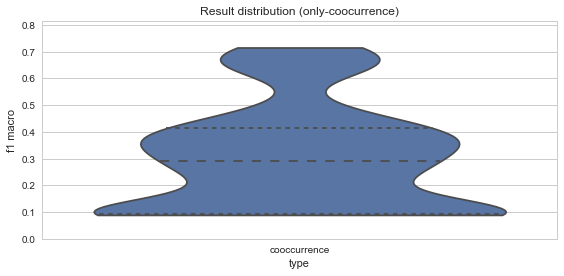

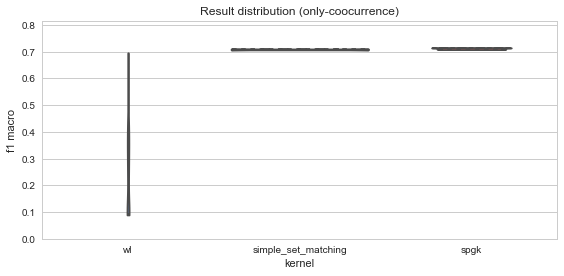

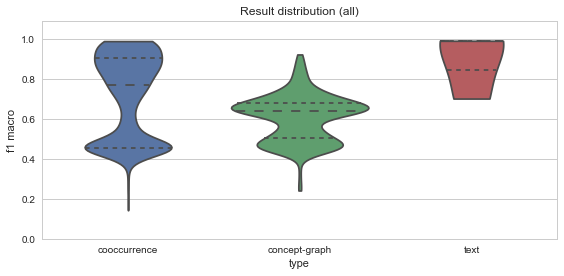

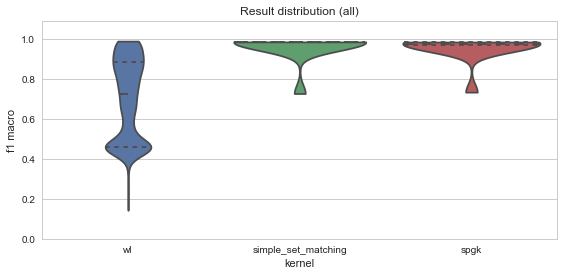

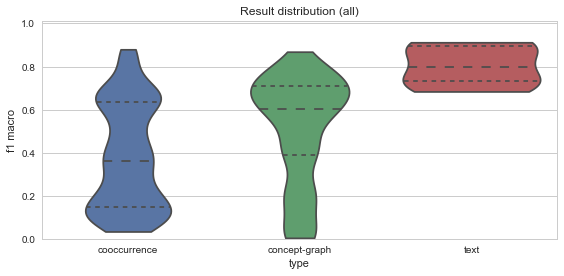

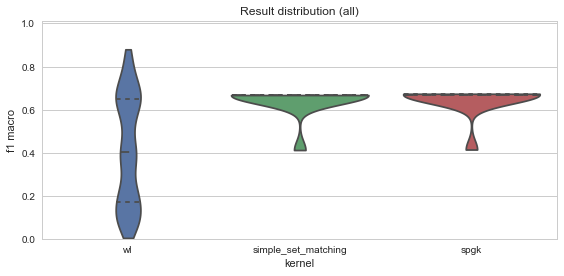

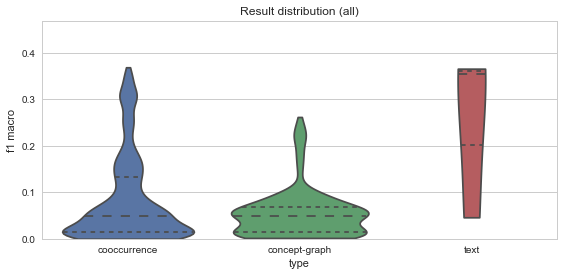

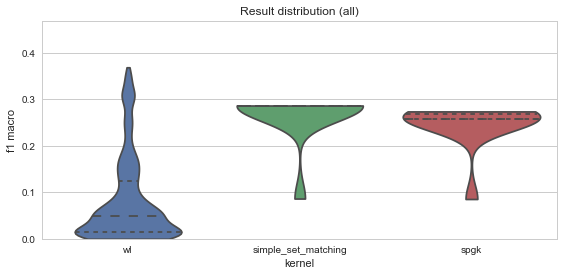

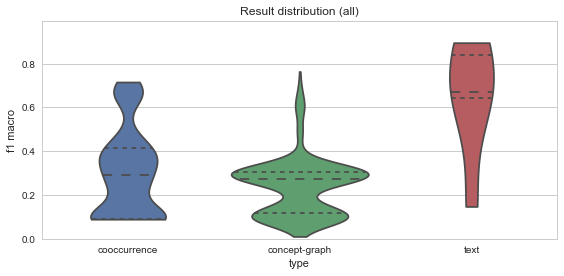

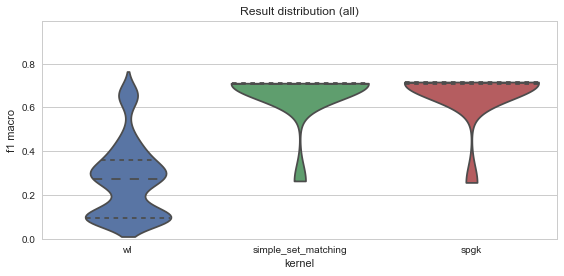

In [8]:
for data_filter_name, data_filter in [('only-concept-graphs', df_all.type == 'concept-graph'), ('only-coocurrence', df_all.type == 'cooccurrence'), ('all', df_all.type != 'YES')]:
    for dataset_name, df in df_all[data_filter].groupby('dataset'):
        for attr in ['type', 'kernel']:
            # Filter out DummyClassifier
            df = df[(df.classifier != 'DummyClassifier')]
            f1_min, f1_max = df.mean_test_f1_macro.min(), df.mean_test_f1_macro.max()
            fig, axes = plt.subplots(figsize = EXPORT_FIG_SIZE)
            ax = sns.violinplot(x = attr, y = 'mean_test_f1_macro', data=df, cut = 0, split = True, inner = 'quartile')
            #ax = sns.swarmplot(x = attr, y = 'mean_test_f1_macro', data=df)
            #ax = sns.stripplot(x = attr, y = 'mean_test_f1_macro', data=df, jitter = True)
            ax.set_ylim((0, f1_max + 0.1))
            ax.set_ylabel('f1 macro')
            ax.set_title('Result distribution ({})'.format(data_filter_name));
            fig.tight_layout()
            fig.savefig('tmp/result-distributions/{}-{}-{}.png'.format(dataset_name, data_filter_name, attr), dpi = EXPORT_DPI)
            plt.show()
            plt.close(fig)

## Best classifers per type per dataset

################# ling-spam
concept-graph       best f1-score: 0.9213	words: concepts      wl iteration: stacked  relabeled: 0      is_same_label: 0      kernel: wl     
COMBINED
cooccurrence        best f1-score: 0.9881	words: all           wl iteration: 1        relabeled: 0      is_same_label: 1      kernel: wl     window_size: 1
text                best f1-score: 0.9898	words: all           


,classifier,dataset,filename,lemmatized,accuracy,f1,precision,recall,mean_train_f1_macro,param_scaler,...,same_label,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,threshold,topn,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,PassiveAggressiveClassifier,ling-spam,data/results/2017-09-28_13:47/dataset_graph_gm...,False,0.959611,0.921320,0.926646,0.916222,1.0,None,...,False,0.007828,0.014974,0.016689,0.013444,NaN,NaN,NaN,stacked,concepts
cooccurrence,PassiveAggressiveClassifier,ling-spam,data/results/2017-09-28_13:47/dataset_graph_co...,True,0.993432,0.988143,0.988581,0.987748,1.0,NaN,...,True,0.000486,0.000911,0.001705,0.003357,NaN,NaN,1,1,all
text,PassiveAggressiveClassifier,ling-spam,data/results/2017-09-28_13:47/text_ling-spam.r...,False,0.994307,0.989756,0.988943,0.990701,1.0,NaN,...,NaN,0.001521,0.002750,0.005102,0.005182,NaN,NaN,NaN,NaN,all


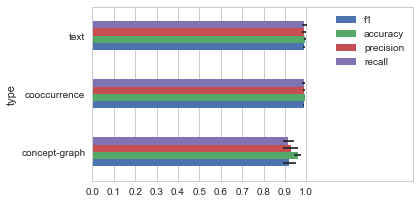

################# ng20
concept-graph       best f1-score: 0.8689	words: concepts      wl iteration: stacked  relabeled: 0      is_same_label: 0      kernel: wl     
COMBINED
cooccurrence        best f1-score: 0.8799	words: all           wl iteration: 0        relabeled: 0      is_same_label: 0      kernel: wl     window_size: 2
text                best f1-score: 0.9126	words: all           


,classifier,dataset,filename,lemmatized,accuracy,f1,precision,recall,mean_train_f1_macro,param_scaler,...,same_label,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,threshold,topn,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,MultinomialNB,ng20,data/results/2017-09-28_13:47/dataset_graph_gm...,False,0.870505,0.868927,0.876821,0.866073,0.995698,None,...,False,0.001502,0.001420,0.001677,0.001361,NaN,NaN,NaN,stacked,concepts
cooccurrence,LinearSVC,ng20,data/results/2017-09-28_13:47/dataset_graph_co...,False,0.881303,0.879939,0.881728,0.878878,0.999694,NaN,...,False,0.001393,0.001434,0.001077,0.001645,NaN,NaN,2,0,all
text,LinearSVC,ng20,data/results/2017-09-28_13:47/text_ng20-ana.re...,False,0.914672,0.912572,0.914259,0.911714,0.998895,NaN,...,NaN,0.000916,0.000926,0.001478,0.000627,NaN,NaN,NaN,NaN,all


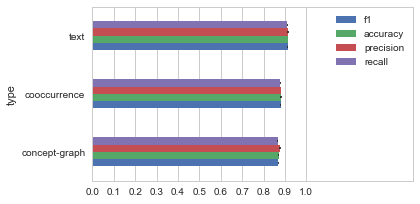

################# reuters-21578
concept-graph       best f1-score: 0.2618	words: concepts      wl iteration: stacked  relabeled: 0      is_same_label: 0      kernel: wl     
cooccurrence        best f1-score: 0.3688	words: only-nouns    wl iteration: 0        relabeled: 0      is_same_label: 0      kernel: wl     window_size: 2
text                best f1-score: 0.3657	words: all           


,classifier,dataset,filename,lemmatized,accuracy,f1,precision,recall,mean_train_f1_macro,param_scaler,...,same_label,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,threshold,topn,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,MultinomialNB,reuters-21578,data/results/2017-09-28_13:47/dataset_graph_gm...,False,0.645068,0.261841,0.312178,0.241450,0.655145,None,...,False,0.004597,0.012473,0.012906,0.014774,NaN,NaN,NaN,stacked,concepts
cooccurrence,LinearSVC,reuters-21578,data/results/2017-09-28_13:47/dataset_graph_co...,True,0.684649,0.368753,0.335444,0.482245,0.557646,"Normalizer(copy=True, norm='l1')",...,False,0.002925,0.012968,0.009564,0.020571,NaN,NaN,2,0,only-nouns
text,LinearSVC,reuters-21578,data/results/2017-09-28_13:47/text_reuters-215...,False,0.692355,0.365727,0.358199,0.395505,0.694682,NaN,...,NaN,0.001256,0.009152,0.017736,0.006869,NaN,NaN,NaN,NaN,all


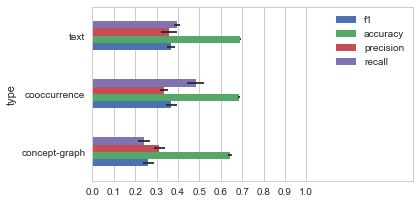

################# webkb
concept-graph       best f1-score: 0.7635	words: concepts      wl iteration: stacked  relabeled: 0      is_same_label: 0      kernel: wl     
cooccurrence        best f1-score: 0.7157	words: all           wl iteration: nan      relabeled: 0      is_same_label: 0      kernel: spgk   window_size: 1
text                best f1-score: 0.8953	words: all           


,classifier,dataset,filename,lemmatized,accuracy,f1,precision,recall,mean_train_f1_macro,param_scaler,...,same_label,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro,threshold,topn,window_size,wl_iteration,words
type,,,,,,,,,,,,,,,,,,,,,
concept-graph,MultinomialNB,webkb,data/results/2017-09-28_13:47/dataset_graph_gm...,False,0.816025,0.763539,0.772387,0.769722,0.985173,None,...,False,0.004393,0.018015,0.009042,0.024565,NaN,NaN,NaN,stacked,concepts
cooccurrence,SVC,webkb,data/results/2017-09-28_13:47/dataset_graph_co...,False,0.818709,0.715692,0.735567,0.714197,0.936644,NaN,...,False,0.000676,0.003857,0.015623,0.006441,NaN,NaN,1,NaN,all
text,LinearSVC,webkb,data/results/2017-09-28_13:47/text_webkb-ana.r...,False,0.906550,0.895274,0.900082,0.891651,0.996501,NaN,...,NaN,0.002591,0.003520,0.001054,0.007481,NaN,NaN,NaN,NaN,all


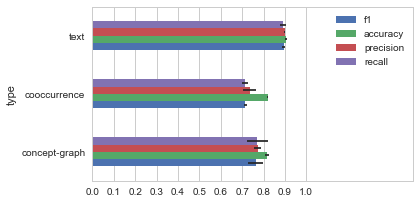

In [9]:
COLUMNS_OF_INTEREST = ['classifier', 'dataset', 'filename', 'lemmatized', 'accuracy', 'f1', 'precision', 'recall', 'mean_train_f1_macro', 'param_scaler', 'params', 'relabeled', 'same_label', 'std_test_accuracy', 'std_test_f1_macro', 'std_test_precision_macro', 'std_test_recall_macro', 'threshold', 'topn', 'window_size', 'wl_iteration', 'words']

def plot_best_by_type(df_all, df, df_dataset, title = '', fontsize = 12, figsize = (6, 3), top = 0.85):
    fig, ax = plt.subplots(figsize = figsize)
    els = df_all.iloc[df['mean_test_f1_macro'].idxmax()]
    els = els.set_index('type')
    els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
    els[['f1', 'accuracy', 'precision', 'recall']].plot(kind = 'barh', ax = ax, xlim = (0, 1.5), xerr=[els.std_test_f1_macro * 2,  els.std_test_accuracy * 2,  els.std_test_precision_macro * 2,  els.std_test_recall_macro * 2])
    #    df['mean_test_f1_macro'].max().plot(kind = 'barh', ax = ax, xlim = (0, 1))#)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.grid(axis = 'y')
    for set_type, x in els.iterrows():
        out = '{:20}best f1-score: {x.f1:.4f}\twords: {x.words:14}'.format(set_type, x = x)
        if x.combined is True:
            print('COMBINED')
        if set_type != 'text':
            out += 'wl iteration: {x.wl_iteration:<8} relabeled: {x.relabeled:<6} is_same_label: {x.same_label:<6} kernel: {x.kernel:<7}'.format(x = x)
        else:
            #out += 'stop words:   {}'.format(x.params["count_vectorizer__stop_words"])
            pass
        if set_type == 'cooccurrence':
            out += 'window_size: {x.window_size}'.format(x = x)
        print(out)
    display(els[COLUMNS_OF_INTEREST])
    if title and title != '':
        fig.suptitle(title, fontsize = fontsize)
    fig.tight_layout()
    if title and title != '':
        fig.subplots_adjust(top = top)
    return fig, ax

for name, df_dataset in sorted(df_all[df_all.wl_iteration != 0].groupby('dataset'), key = lambda x: x[0]):
    df_dataset_grouped_by_type = df_dataset.groupby('type')
    print('################# {}'.format(name))
    use_title = False
    fig, ax = plot_best_by_type(df_all, df_dataset_grouped_by_type, df_dataset, 'Dataset: {}'.format(name) if use_title else None)
    fig.savefig('tmp/results/dataset-{}-best.png'.format(name), dpi = 150)
    plt.show()
    plt.close(fig)


## Plot best per parameter value per dataset

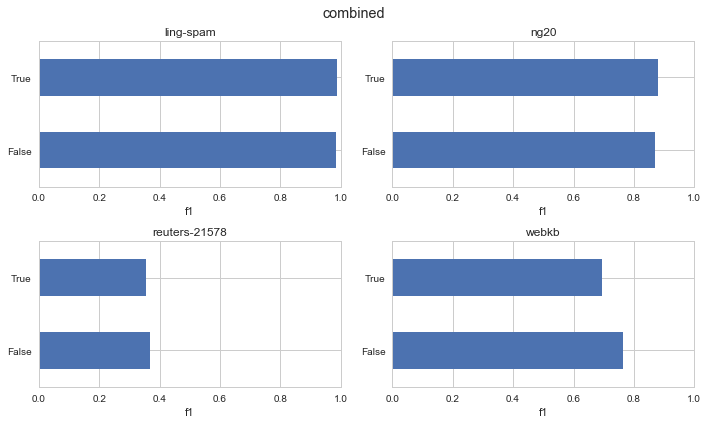

In [10]:
def graphs_grouped_by_plot(df_all, groupby):
    df_graphs_grouped = df_all[df_all.type != 'text'].groupby('dataset')
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10, 6))
    for idx, (dataset_name, df_dataset) in enumerate(df_graphs_grouped):
        ax = axes[int(idx / 2), idx % 2]
        grouped = df_dataset.groupby(groupby)
        els = df_all.iloc[grouped.mean_test_f1_macro.idxmax()]
        els = els.set_index(groupby)
        #threshold = els[els.threshold > 0].iloc[0].threshold
        els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
        els[['f1']].plot(kind = 'barh', ax = ax, legend = False, xlim = (0, 1), title = dataset_name)
        ax.set_xlabel('f1')
        ax.set_ylabel('')

    fig.tight_layout()
    fig.suptitle(groupby)
    fig.subplots_adjust(top = 0.9)
    fig.savefig('tmp/results/{}.png'.format(groupby), dpi = 150)
    plt.show()

if 1 == 1:
    graphs_grouped_by_plot(df_all, 'combined')

## Plot by parameter

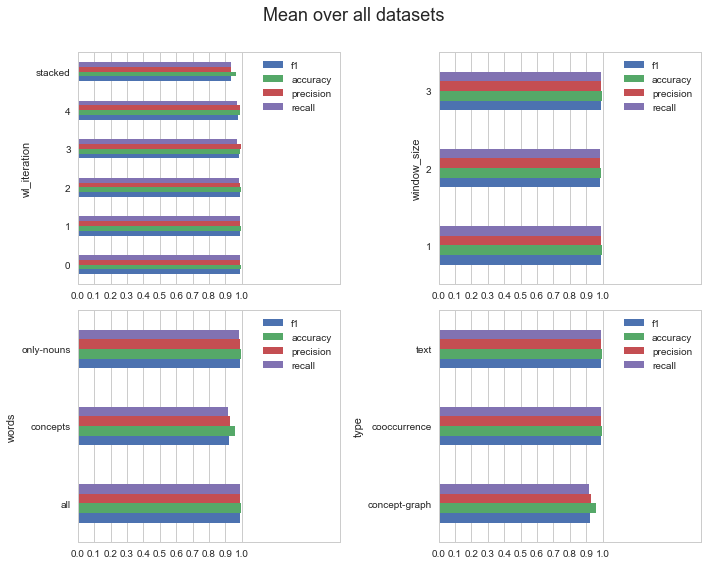

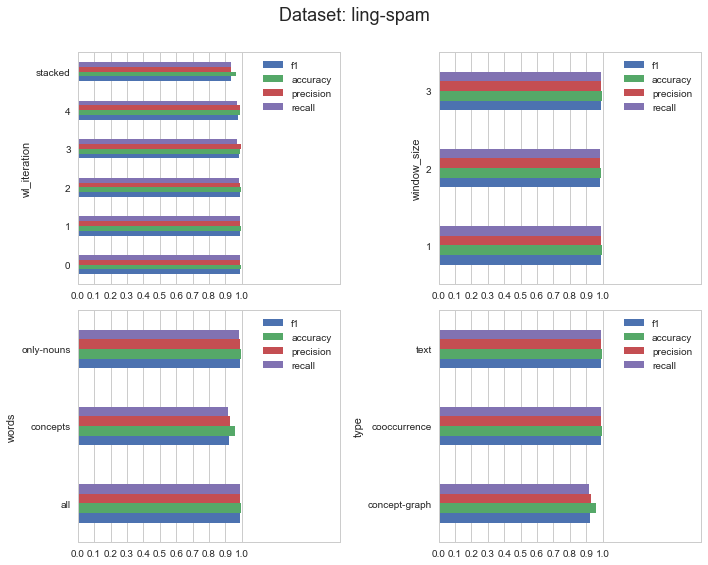

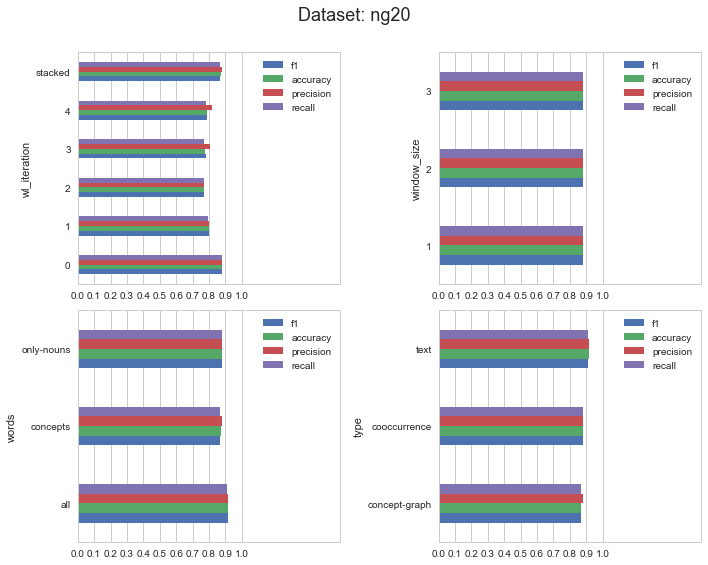

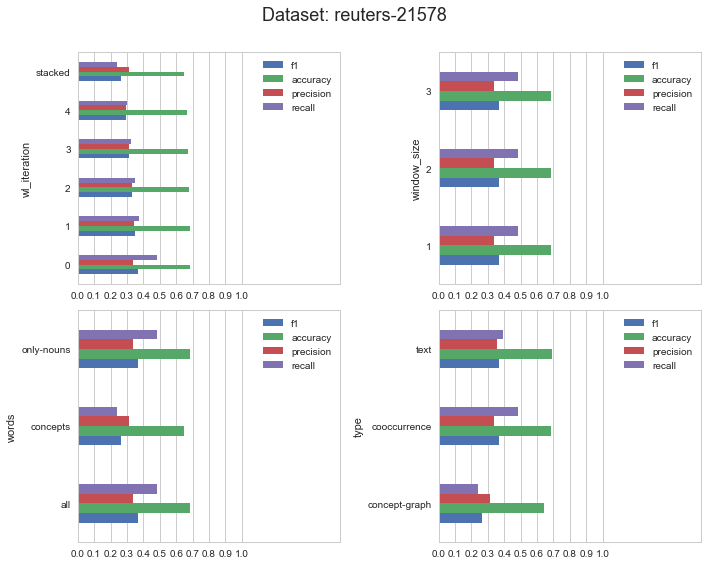

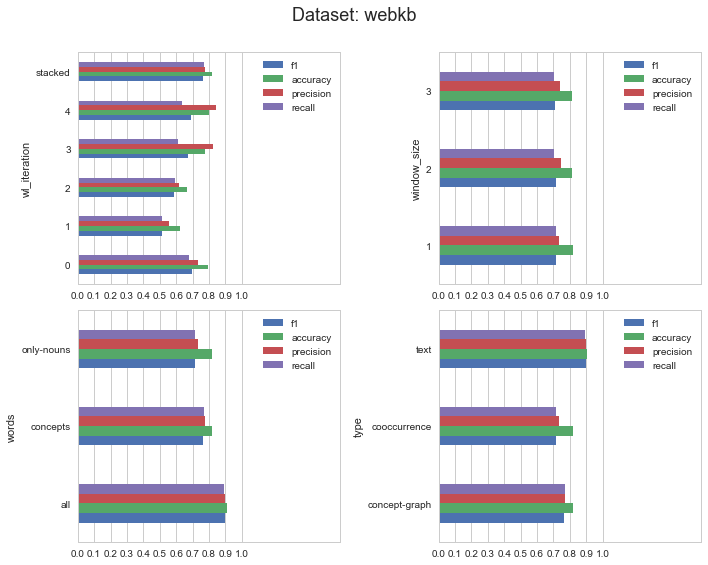

In [11]:
def plot_distributions(df, df_all, title = None, figsize = (10, 8)):
    fig, axes_indexed = plt.subplots(nrows = 2, ncols=2, figsize = figsize)

    axes = []
    for ax_row in axes_indexed:
        axes += list(ax_row)
    #, 'relabeled'
    for val, ax in zip(['wl_iteration', 'window_size', 'words', 'type'], axes):
        if len(df.groupby(val).size()) == 0:
            continue
        grouped = df.groupby(val)
        els = df_all.iloc[grouped['mean_test_f1_macro'].idxmax()]
        els = els.set_index(val)
        els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
        els[['f1', 'accuracy', 'precision', 'recall']].plot(kind = 'barh', ax = ax, xlim=(0, 2))
        ax.set_xticks(np.linspace(0, 1, 11))
        ax.grid(axis = 'y')
        ax.set_xlim((0, 1.6))
    plt.suptitle(title, size = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    return fig, axes
    
dpi = 150

if 1 == 1:
    fig, _  = plot_distributions(df_all, df_all, title = 'Mean over all datasets')
    fig.savefig('tmp/results/all.png', dpi = dpi)
    plt.show()
    plt.close(fig)
    for name, df_dataset in df_all.groupby('dataset'):
        if len(df_dataset.type.value_counts()) < 3:
            continue
        fig, _ = plot_distributions(df_dataset, df_all, title = 'Dataset: {}'.format(name))
        fig.savefig('tmp/results/dataset-{}.png'.format(name), dpi = dpi)
        plt.show()
        plt.close(fig)

import dataset_helper
import matplotlib.pyplot as plt

currently = ['ling-spam', 'webkb', 'ng20', 'reuters-21578']

for dataset in dataset_helper.get_all_available_dataset_names():
    if dataset not in currently: continue
    X, Y = dataset_helper.get_dataset(dataset)
    unique_classes = set(Y)
    fig, ax = plt.subplots(figsize = (12, min(14, len(unique_classes) / 3)))
    print('{}\n#Docs:\t{}\t# Classes:\t{}'.format(dataset, len(X), len(unique_classes)))
    dataset_helper.plot_dataset_class_distribution(X, Y, 'Class distribution: {}'.format(dataset), ax = ax)
    plt.show()